In [4]:
import ee, datetime as dt
import pandas as pd
import requests, time
import numpy as np

import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt

In [5]:
# Load environment variables
load_dotenv()
OPENAQ_API_KEY = os.getenv("OPENAQ_API_KEY")
HEADERS = {"X-API-Key": OPENAQ_API_KEY}  

BBOX_DELHI  = [76.75, 28.35, 77.45, 28.95]
BBOX_LAGOS  = [ 3.00,  6.30,  3.60,  6.80]
BBOX_JAKARTA = [106.70, -6.40, 107.00, -6.05]

DATE_FROM   = '2018-01-01'
DATE_TO     = '2024-12-31'

In [6]:
API = 'https://api.openaq.org/v3/locations' 

def get_pm25_bbox(bbox, date_from, date_to, sleep=0.5, max_pages=50):
    """Return a DataFrame of raw PM2.5 readings in the bounding box."""
    params_base = {
        'parameters_id': 2,                   # PM2.5
        'datetime_from'  : date_from,
        'datetime_to'    : date_to,
        'bbox'       : ','.join(map(str, bbox)),
        'limit'      : 100,                  # max per request
        'page'       : 1
    }
    rows = []
    for page in range(1, max_pages + 1):
        params = params_base | {'page': page}
        r = requests.get(API, params=params, headers=HEADERS).json()
        rows.extend(r['results'])
        if page * params_base['limit'] >= r['meta']['found']:
            break
        time.sleep(sleep)                    # be kind to the API
    return pd.json_normalize(rows)

df_delhi_raw  = get_pm25_bbox(BBOX_DELHI,  DATE_FROM, DATE_TO)
df_lagos_raw  = get_pm25_bbox(BBOX_LAGOS,  DATE_FROM, DATE_TO)


In [7]:
df_jakarta_raw = get_pm25_bbox(BBOX_JAKARTA, DATE_FROM, DATE_TO)

In [8]:
OAQ = 'https://api.openaq.org/v3'
LIMIT = 100    

def stations_in_bbox(bbox):
    params = {
        'parameters_id' : 2,          # PM2.5
        'bbox'         : ','.join(map(str, bbox)),
        'limit'        : 100,        # max page size
        'page'         : 1
    }
    rows = []
    while True:
        r = requests.get(f'{OAQ}/locations', params=params, headers=HEADERS).json()
        rows.extend(r['results'])
        if params['page'] * params['limit'] >= r['meta']['found']:
            break
        params['page'] += 1; time.sleep(0.4)     # polite paging
    return pd.json_normalize(rows)

locs_delhi = stations_in_bbox(BBOX_DELHI)
locs_lagos = stations_in_bbox(BBOX_LAGOS)

print(locs_delhi[['id','name','coordinates.latitude','coordinates.longitude']].head())
print(locs_lagos[['id','name','coordinates.latitude','coordinates.longitude']].head())


   id                                          name  coordinates.latitude  \
0  13  Delhi Technological University, Delhi - CPCB             28.744000   
1  15                                   IGI Airport             28.560000   
2  16                                   Civil Lines             28.678700   
3  17                       R K Puram, Delhi - DPCC             28.563262   
4  50                    Punjabi Bagh, Delhi - DPCC             28.674045   

   coordinates.longitude  
0              77.120000  
1              77.094000  
2              77.226200  
3              77.186937  
4              77.131023  
       id   name  coordinates.latitude  coordinates.longitude
0  404479  Lagos              6.440483               3.406815


In [9]:
locs_jakarta = stations_in_bbox(BBOX_JAKARTA)
print(locs_jakarta[['id','name','coordinates.latitude','coordinates.longitude']].head())

       id                                 name  coordinates.latitude  \
0    2537    US Diplomatic Post: Jakarta South             -6.236585   
1    2538  US Diplomatic Post: Jakarta Central             -6.182382   
2    8320                        Jakarta South             -6.236704   
3    8637                      Jakarta Central             -6.182536   
4  223262                             Cilandek             -6.274139   

   coordinates.longitude  
0             106.793335  
1             106.834094  
2             106.793244  
3             106.834235  
4             106.799896  


In [10]:
def get_sensors_for_location(location_id):
    """Get sensors for a specific location ID"""
    r = requests.get(f'{OAQ}/locations/{location_id}/sensors', headers=HEADERS).json()
    if 'results' in r:
        return r['results']
    return []

# Get sensors for each location
delhi_sensors = []
for idx, row in locs_delhi.iterrows():
    loc_id = row['id']
    sensors = get_sensors_for_location(loc_id)
    # Add location id and coordinates to each sensor
    for sensor in sensors:
        sensor['location_id'] = loc_id
        sensor['latitude'] = row['coordinates.latitude']
        sensor['longitude'] = row['coordinates.longitude']
    delhi_sensors.extend(sensors)
    time.sleep(0.3)  # polite paging

# Convert to DataFrames
delhi_sensors_df = pd.json_normalize(delhi_sensors) if delhi_sensors else pd.DataFrame()
print("Delhi sensors count:", len(delhi_sensors_df))

Delhi sensors count: 450


In [15]:
lagos_sensors = []
for idx, row in locs_lagos.iterrows():
    loc_id = row['id']
    sensors = get_sensors_for_location(loc_id)
    # Add location id and coordinates to each sensor
    for sensor in sensors:
        sensor['location_id'] = loc_id
        sensor['latitude'] = row['coordinates.latitude']
        sensor['longitude'] = row['coordinates.longitude']
    lagos_sensors.extend(sensors)
    time.sleep(0.3)  # polite paging

lagos_sensors_df = pd.json_normalize(lagos_sensors) if lagos_sensors else pd.DataFrame()
print("Lagos sensors count:", len(lagos_sensors_df))

Lagos sensors count: 1


In [16]:
# Filter sensors for PM2.5 measurements
delhi_pm25_sensors_df = delhi_sensors_df[delhi_sensors_df['parameter.name'] == 'pm25']
delhi_pm25_sensors_df = delhi_pm25_sensors_df.reset_index(drop=True)

lagos_pm25_sensors_df = lagos_sensors_df[lagos_sensors_df['parameter.name'] == 'pm25']
lagos_pm25_sensors_df = lagos_pm25_sensors_df.reset_index(drop=True)

print("Delhi PM2.5 sensors count:", len(delhi_pm25_sensors_df))
print("Lagos PM2.5 sensors count:", len(lagos_pm25_sensors_df))

# Display the first few rows of the filtered dataframes
print("\nDelhi PM2.5 sensors:")
if not delhi_pm25_sensors_df.empty:
    print(delhi_pm25_sensors_df[['id', 'name', 'parameter.name', 'parameter.units', 'datetimeFirst.utc', 'datetimeLast.utc']])
else:
    print("No PM2.5 sensors found in Delhi")

print("\nLagos PM2.5 sensors:")
if not lagos_pm25_sensors_df.empty:
    print(lagos_pm25_sensors_df[['id', 'name', 'parameter.name', 'parameter.units']].head())
else:
    print("No PM2.5 sensors found in Lagos")


Delhi PM2.5 sensors count: 72
Lagos PM2.5 sensors count: 1

Delhi PM2.5 sensors:
          id        name parameter.name parameter.units     datetimeFirst.utc  \
0      13864  pm25 µg/m³           pm25           µg/m³  2016-11-02T19:00:00Z   
1         30  pm25 µg/m³           pm25           µg/m³                   NaN   
2         34  pm25 µg/m³           pm25           µg/m³                   NaN   
3         35  pm25 µg/m³           pm25           µg/m³  2016-02-05T14:55:00Z   
4   12234787  pm25 µg/m³           pm25           µg/m³  2025-02-18T20:15:00Z   
..       ...         ...            ...             ...                   ...   
67  12234735  pm25 µg/m³           pm25           µg/m³  2025-02-18T20:15:00Z   
68     19884  pm25 µg/m³           pm25           µg/m³  2019-04-27T12:00:00Z   
69  12235779  pm25 µg/m³           pm25           µg/m³  2025-02-18T20:15:00Z   
70     19900  pm25 µg/m³           pm25           µg/m³  2018-08-10T07:00:00Z   
71  12235047  pm25 µg/m³    

In [17]:
def measurements_for_sensor(sid, start, stop, lat=None, lon=None, location_id=None):
    """Return *all* rows for one sensor between dates."""
    rows, page = [], 1
    while True:
        params = {
            'datetime_from': start,
            'datetime_to': stop,
            'limit': LIMIT,
            'page': page
        }
        url = f'{OAQ}/sensors/{sid}/measurements/daily'
        response = requests.get(url, params=params, headers=HEADERS)
        try:
            r = response.json()
        except Exception as e:
            print("Failed to decode JSON!")
            print("Status code:", response.status_code)
            print("Response text:", response.text)
            raise e

            # Defensive: check for 'results'
        if 'results' not in r or not isinstance(r['results'], list):
                print("Skipping page", page, "due to unexpected API response structure:", r)
                page += 1
                time.sleep(0.4)
                continue

        # If 'results' is an empty list, we've reached the end
        if not r['results']:
            break

        # Attach sid, lat, lon to each measurement
        for entry in r['results']:
            entry['sid'] = sid
            entry['location_id'] = location_id
            entry['latitude'] = lat
            entry['longitude'] = lon

        rows.extend(r['results'])
        page += 1
        time.sleep(0.4)
    return rows

def city_measurements(sensor_df, start, stop):
    all_rows = []
    for _, row in sensor_df.iterrows():
        sid = row['id']
        location_id = row['location_id']
        lat = row['latitude']
        lon = row['longitude']
        all_rows.extend(measurements_for_sensor(sid, DATE_FROM, DATE_TO, lat, lon, location_id))
        time.sleep(1)
    print(len(all_rows))
    return pd.json_normalize(all_rows)

df_delhi_raw = city_measurements(delhi_pm25_sensors_df, DATE_FROM, DATE_TO)
df_lagos_raw = city_measurements(lagos_pm25_sensors_df, DATE_FROM, DATE_TO)

Skipping page 1 due to unexpected API response structure: {'detail': 'Too many requests'}
Skipping page 1 due to unexpected API response structure: {'detail': 'Too many requests'}
Skipping page 2 due to unexpected API response structure: {'detail': 'Too many requests'}
17518
353


In [31]:
original_df_delhi = df_delhi_raw
original_df_lagos = df_lagos_raw

original_df_delhi.to_csv('original_delhi_daily_pm25.csv', index=False)
original_df_lagos.to_csv('original_lagos_daily_pm25.csv', index=False)


### Data Cleaning!

In [23]:
# Display the columns of df_delhi_raw
print("Columns in df_delhi_raw:")
print(df_delhi_raw.columns.tolist())

# Also show a sample of the dataframe to understand the data
df_delhi_raw

Columns in df_delhi_raw:
['value', 'coordinates', 'sid', 'location_id', 'latitude', 'longitude', 'flagInfo.hasFlags', 'parameter.id', 'parameter.name', 'parameter.units', 'parameter.displayName', 'period.label', 'period.interval', 'period.datetimeFrom.utc', 'period.datetimeFrom.local', 'period.datetimeTo.utc', 'period.datetimeTo.local', 'summary.min', 'summary.q02', 'summary.q25', 'summary.median', 'summary.q75', 'summary.q98', 'summary.max', 'summary.avg', 'summary.sd', 'coverage.expectedCount', 'coverage.expectedInterval', 'coverage.observedCount', 'coverage.observedInterval', 'coverage.percentComplete', 'coverage.percentCoverage', 'coverage.datetimeFrom.utc', 'coverage.datetimeFrom.local', 'coverage.datetimeTo.utc', 'coverage.datetimeTo.local']


,value,coordinates,sid,location_id,latitude,longitude,flagInfo.hasFlags,parameter.id,parameter.name,parameter.units,...,coverage.expectedCount,coverage.expectedInterval,coverage.observedCount,coverage.observedInterval,coverage.percentComplete,coverage.percentCoverage,coverage.datetimeFrom.utc,coverage.datetimeFrom.local,coverage.datetimeTo.utc,coverage.datetimeTo.local
0,304.0,None,13864,13,28.744000,77.120000,False,2,pm25,µg/m³,...,24,06:00:00,53,13:15:00,221.0,55.0,2017-12-31T17:45:00Z,2017-12-31T23:15:00+05:30,2018-01-01T18:15:00Z,2018-01-01T23:45:00+05:30
1,269.0,None,13864,13,28.744000,77.120000,False,2,pm25,µg/m³,...,24,06:00:00,64,16:00:00,267.0,67.0,2018-01-01T17:45:00Z,2018-01-01T23:15:00+05:30,2018-01-02T18:15:00Z,2018-01-02T23:45:00+05:30
2,324.0,None,13864,13,28.744000,77.120000,False,2,pm25,µg/m³,...,24,06:00:00,40,10:00:00,167.0,42.0,2018-01-02T18:00:00Z,2018-01-02T23:30:00+05:30,2018-01-03T17:15:00Z,2018-01-03T22:45:00+05:30
3,374.0,None,13864,13,28.744000,77.120000,False,2,pm25,µg/m³,...,24,06:00:00,36,09:00:00,150.0,38.0,2018-01-03T18:00:00Z,2018-01-03T23:30:00+05:30,2018-01-04T18:30:00Z,2018-01-05T00:00:00+05:30
4,417.0,None,13864,13,28.744000,77.120000,False,2,pm25,µg/m³,...,24,06:00:00,54,13:30:00,225.0,56.0,2018-01-04T17:45:00Z,2018-01-04T23:15:00+05:30,2018-01-05T18:30:00Z,2018-01-06T00:00:00+05:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17513,48.7,None,19900,6929,28.611281,77.237738,False,2,pm25,µg/m³,...,96,24:00:00,19,04:45:00,20.0,20.0,2022-10-12T19:00:00Z,2022-10-13T00:30:00+05:30,2022-10-13T18:15:00Z,2022-10-13T23:45:00+05:30
17514,79.3,None,19900,6929,28.611281,77.237738,False,2,pm25,µg/m³,...,96,24:00:00,16,04:00:00,17.0,17.0,2022-10-13T20:00:00Z,2022-10-14T01:30:00+05:30,2022-10-14T18:15:00Z,2022-10-14T23:45:00+05:30
17515,94.6,None,19900,6929,28.611281,77.237738,False,2,pm25,µg/m³,...,96,24:00:00,18,04:30:00,19.0,19.0,2022-10-14T19:00:00Z,2022-10-15T00:30:00+05:30,2022-10-15T18:15:00Z,2022-10-15T23:45:00+05:30
17516,103.0,None,19900,6929,28.611281,77.237738,False,2,pm25,µg/m³,...,96,24:00:00,19,04:45:00,20.0,20.0,2022-10-15T19:00:00Z,2022-10-16T00:30:00+05:30,2022-10-16T15:15:00Z,2022-10-16T20:45:00+05:30


In [24]:
# Make sure the units are all µg/m³
assert df_delhi_raw['parameter.units'].nunique() == 1 and df_delhi_raw['parameter.units'].iloc[0] == 'µg/m³'
assert df_lagos_raw['parameter.units'].nunique() == 1 and df_lagos_raw['parameter.units'].iloc[0] == 'µg/m³'

# # remove infeasible values
df_delhi_raw = df_delhi_raw[(df_delhi_raw.value >= 0) & (df_delhi_raw.value < 1000)]
df_lagos_raw = df_lagos_raw[(df_lagos_raw.value >= 0) & (df_lagos_raw.value < 1000)]

def iqr_filter(g):
    q1, q3 = g.value.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 3*iqr, q3 + 3*iqr        # Tukey fence
    return g[(g.value >= lo) & (g.value <= hi)]

# First, we need to use a column that exists in the dataframe
# Using 'coverage.datetimeFrom.local' instead of 'datetime'
df_delhi_raw = (df_delhi_raw.sort_values(['sid', 'coverage.datetimeFrom.local'])
        .groupby('sid', group_keys=False)
        .apply(iqr_filter))
df_lagos_raw = (df_lagos_raw.sort_values(['sid', 'coverage.datetimeFrom.local'])
        .groupby('sid', group_keys=False)
        .apply(iqr_filter))

/var/folders/xp/ycg8s5194736y0vn0h3_t5dm0000gn/T/ipykernel_45312/3012801410.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(iqr_filter))
/var/folders/xp/ycg8s5194736y0vn0h3_t5dm0000gn/T/ipykernel_45312/3012801410.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(iqr_filter))


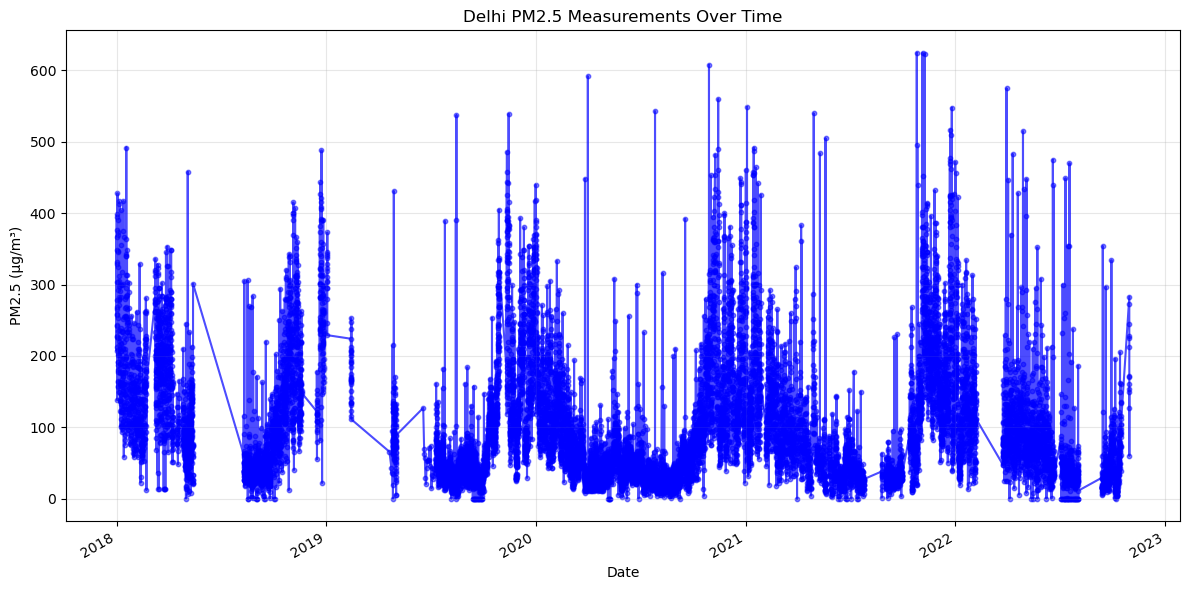

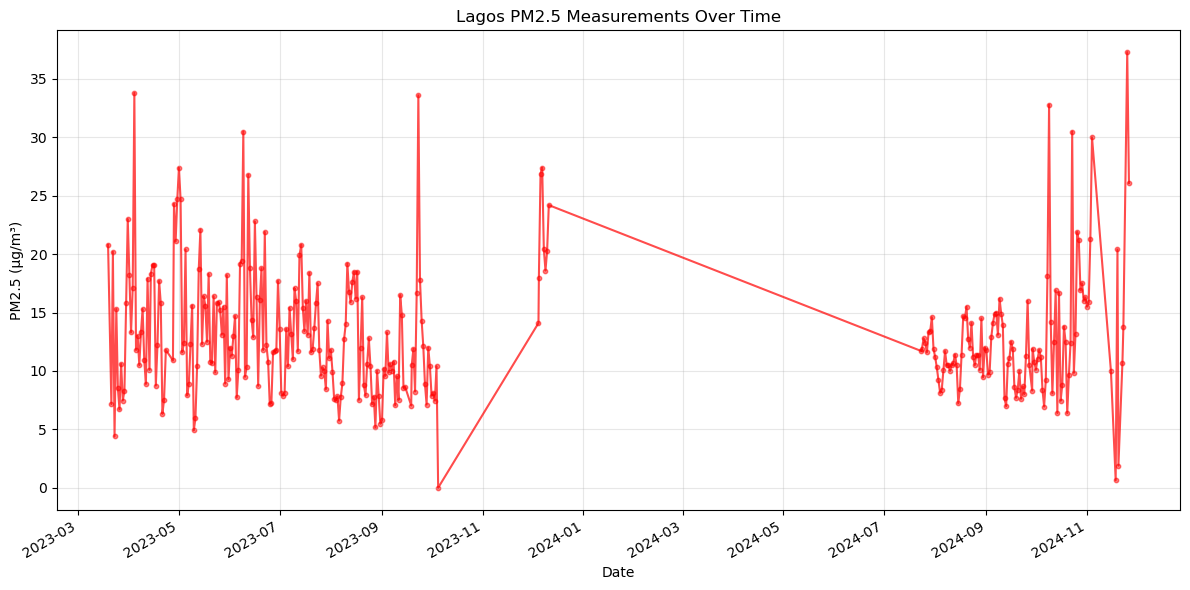

Delhi Statistics:
Number of measurements: 17332
Date range: 2017-12-31 23:15:00+05:30 to 2022-10-31 07:15:00+05:30
Average PM2.5: 102.50 µg/m³
Maximum PM2.5: 625.00 µg/m³

Lagos Statistics:
Number of measurements: 316
Date range: 2023-03-19 02:00:00+01:00 to 2024-11-26 09:00:00+01:00
Average PM2.5: 13.11 µg/m³
Maximum PM2.5: 37.30 µg/m³


In [25]:
# Convert the datetime strings to datetime objects for plotting
df_delhi_raw['datetime'] = pd.to_datetime(df_delhi_raw['coverage.datetimeFrom.local'])
df_delhi_raw_sorted = df_delhi_raw.sort_values('datetime')

df_lagos_raw['datetime'] = pd.to_datetime(df_lagos_raw['coverage.datetimeFrom.local'])
df_lagos_raw_sorted = df_lagos_raw.sort_values('datetime')

# Create a time series plot for Delhi
plt.figure(figsize=(12, 6))
plt.plot(df_delhi_raw_sorted['datetime'], df_delhi_raw_sorted['value'], 'b-', alpha=0.7)
plt.scatter(df_delhi_raw_sorted['datetime'], df_delhi_raw_sorted['value'], s=10, alpha=0.5, color='blue')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Delhi PM2.5 Measurements Over Time')
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a separate time series plot for Lagos
plt.figure(figsize=(12, 6))
plt.plot(df_lagos_raw_sorted['datetime'], df_lagos_raw_sorted['value'], 'r-', alpha=0.7)
plt.scatter(df_lagos_raw_sorted['datetime'], df_lagos_raw_sorted['value'], s=10, alpha=0.5, color='red')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Lagos PM2.5 Measurements Over Time')
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics for both cities
print("Delhi Statistics:")
print(f"Number of measurements: {len(df_delhi_raw)}")
print(f"Date range: {df_delhi_raw_sorted['datetime'].min()} to {df_delhi_raw_sorted['datetime'].max()}")
print(f"Average PM2.5: {df_delhi_raw['value'].mean():.2f} µg/m³")
print(f"Maximum PM2.5: {df_delhi_raw['value'].max():.2f} µg/m³")

print("\nLagos Statistics:")
print(f"Number of measurements: {len(df_lagos_raw)}")
print(f"Date range: {df_lagos_raw_sorted['datetime'].min()} to {df_lagos_raw_sorted['datetime'].max()}")
print(f"Average PM2.5: {df_lagos_raw['value'].mean():.2f} µg/m³")
print(f"Maximum PM2.5: {df_lagos_raw['value'].max():.2f} µg/m³")

In [26]:
# Display the columns of the Delhi dataframe
print("Delhi DataFrame Columns:")
print(df_delhi_raw.columns.tolist())

# Show a sample of the dataframe with all columns
print("\nSample of Delhi DataFrame:")
df_delhi_raw.head()

# Print summary statistics for both cities
print("\nDelhi Summary Statistics from OpenAQ:")
print(f"Average PM2.5 (summary.avg): {df_delhi_raw['summary.avg'].mean():.2f} µg/m³")
print(f"Standard Deviation (summary.sd): {df_delhi_raw['summary.sd'].mean():.2f} µg/m³")

print("\nLagos Summary Statistics from OpenAQ:")
print(f"Average PM2.5 (summary.avg): {df_lagos_raw['summary.avg'].mean():.2f} µg/m³")
print(f"Standard Deviation (summary.sd): {df_lagos_raw['summary.sd'].mean():.2f} µg/m³")

# Display a sample of the summary columns for Delhi
print("\nSample of Delhi summary.avg and summary.sd values:")
print(df_delhi_raw[['datetime', 'value', 'summary.avg', 'summary.sd']].head())

# Display a sample of the summary columns for Lagos
print("\nSample of Lagos summary.avg and summary.sd values:")
print(df_lagos_raw[['datetime', 'value', 'summary.avg', 'summary.sd']].head())

df_delhi_raw


Delhi DataFrame Columns:
['value', 'coordinates', 'sid', 'location_id', 'latitude', 'longitude', 'flagInfo.hasFlags', 'parameter.id', 'parameter.name', 'parameter.units', 'parameter.displayName', 'period.label', 'period.interval', 'period.datetimeFrom.utc', 'period.datetimeFrom.local', 'period.datetimeTo.utc', 'period.datetimeTo.local', 'summary.min', 'summary.q02', 'summary.q25', 'summary.median', 'summary.q75', 'summary.q98', 'summary.max', 'summary.avg', 'summary.sd', 'coverage.expectedCount', 'coverage.expectedInterval', 'coverage.observedCount', 'coverage.observedInterval', 'coverage.percentComplete', 'coverage.percentCoverage', 'coverage.datetimeFrom.utc', 'coverage.datetimeFrom.local', 'coverage.datetimeTo.utc', 'coverage.datetimeTo.local', 'datetime']

Sample of Delhi DataFrame:

Delhi Summary Statistics from OpenAQ:
Average PM2.5 (summary.avg): 102.49 µg/m³
Standard Deviation (summary.sd): 40.63 µg/m³

Lagos Summary Statistics from OpenAQ:
Average PM2.5 (summary.avg): 13.11 µg

,value,coordinates,sid,location_id,latitude,longitude,flagInfo.hasFlags,parameter.id,parameter.name,parameter.units,...,coverage.expectedInterval,coverage.observedCount,coverage.observedInterval,coverage.percentComplete,coverage.percentCoverage,coverage.datetimeFrom.utc,coverage.datetimeFrom.local,coverage.datetimeTo.utc,coverage.datetimeTo.local,datetime
52,259.0,None,35,17,28.563262,77.186937,False,2,pm25,µg/m³,...,24:00:00,11,02:45:00,11.0,11.0,2018-01-01T06:30:00Z,2018-01-01T12:00:00+05:30,2018-01-01T14:30:00Z,2018-01-01T20:00:00+05:30,2018-01-01 12:00:00+05:30
53,257.0,None,35,17,28.563262,77.186937,False,2,pm25,µg/m³,...,24:00:00,7,01:45:00,7.0,7.0,2018-01-02T07:15:00Z,2018-01-02T12:45:00+05:30,2018-01-02T12:15:00Z,2018-01-02T17:45:00+05:30,2018-01-02 12:45:00+05:30
54,253.0,None,35,17,28.563262,77.186937,False,2,pm25,µg/m³,...,24:00:00,15,03:45:00,16.0,16.0,2018-01-03T04:30:00Z,2018-01-03T10:00:00+05:30,2018-01-03T18:30:00Z,2018-01-04T00:00:00+05:30,2018-01-03 10:00:00+05:30
55,192.0,None,35,17,28.563262,77.186937,False,2,pm25,µg/m³,...,24:00:00,28,07:00:00,29.0,29.0,2018-01-03T19:00:00Z,2018-01-04T00:30:00+05:30,2018-01-04T18:15:00Z,2018-01-04T23:45:00+05:30,2018-01-04 00:30:00+05:30
56,236.0,None,35,17,28.563262,77.186937,False,2,pm25,µg/m³,...,24:00:00,31,07:45:00,32.0,32.0,2018-01-04T18:30:00Z,2018-01-05T00:00:00+05:30,2018-01-05T18:15:00Z,2018-01-05T23:45:00+05:30,2018-01-05 00:00:00+05:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17513,48.7,None,19900,6929,28.611281,77.237738,False,2,pm25,µg/m³,...,24:00:00,19,04:45:00,20.0,20.0,2022-10-12T19:00:00Z,2022-10-13T00:30:00+05:30,2022-10-13T18:15:00Z,2022-10-13T23:45:00+05:30,2022-10-13 00:30:00+05:30
17514,79.3,None,19900,6929,28.611281,77.237738,False,2,pm25,µg/m³,...,24:00:00,16,04:00:00,17.0,17.0,2022-10-13T20:00:00Z,2022-10-14T01:30:00+05:30,2022-10-14T18:15:00Z,2022-10-14T23:45:00+05:30,2022-10-14 01:30:00+05:30
17515,94.6,None,19900,6929,28.611281,77.237738,False,2,pm25,µg/m³,...,24:00:00,18,04:30:00,19.0,19.0,2022-10-14T19:00:00Z,2022-10-15T00:30:00+05:30,2022-10-15T18:15:00Z,2022-10-15T23:45:00+05:30,2022-10-15 00:30:00+05:30
17516,103.0,None,19900,6929,28.611281,77.237738,False,2,pm25,µg/m³,...,24:00:00,19,04:45:00,20.0,20.0,2022-10-15T19:00:00Z,2022-10-16T00:30:00+05:30,2022-10-16T15:15:00Z,2022-10-16T20:45:00+05:30,2022-10-16 00:30:00+05:30


Delhi Weekly Aggregated Data:
   sid       week   pm25_mean  pm25_median  pm25_min  pm25_max   latitude  \
0   35 2017-12-26  259.000000        259.0     259.0     259.0  28.563262   
1   35 2018-01-02  214.000000        225.0     159.0     257.0  28.563262   
2   35 2018-01-09  194.142857        197.0     157.0     267.0  28.563262   
3   35 2018-01-16  266.333333        262.0     233.0     314.0  28.563262   
4   35 2018-01-23  181.800000        184.0     127.0     228.0  28.563262   

   longitude  location_id parameter_name parameter_units  measurements  
0  77.186937           17           pm25           µg/m³             1  
1  77.186937           17           pm25           µg/m³             7  
2  77.186937           17           pm25           µg/m³             7  
3  77.186937           17           pm25           µg/m³             6  
4  77.186937           17           pm25           µg/m³             5  

Total weeks of data: 2948

Lagos Weekly Aggregated Data:
       sid 

/var/folders/xp/ycg8s5194736y0vn0h3_t5dm0000gn/T/ipykernel_45312/807931403.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_delhi_raw['week'] = df_delhi_raw['datetime'].dt.to_period('W-MON').dt.start_time
/var/folders/xp/ycg8s5194736y0vn0h3_t5dm0000gn/T/ipykernel_45312/807931403.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_lagos_raw['week'] = df_lagos_raw['datetime'].dt.to_period('W-MON').dt.start_time


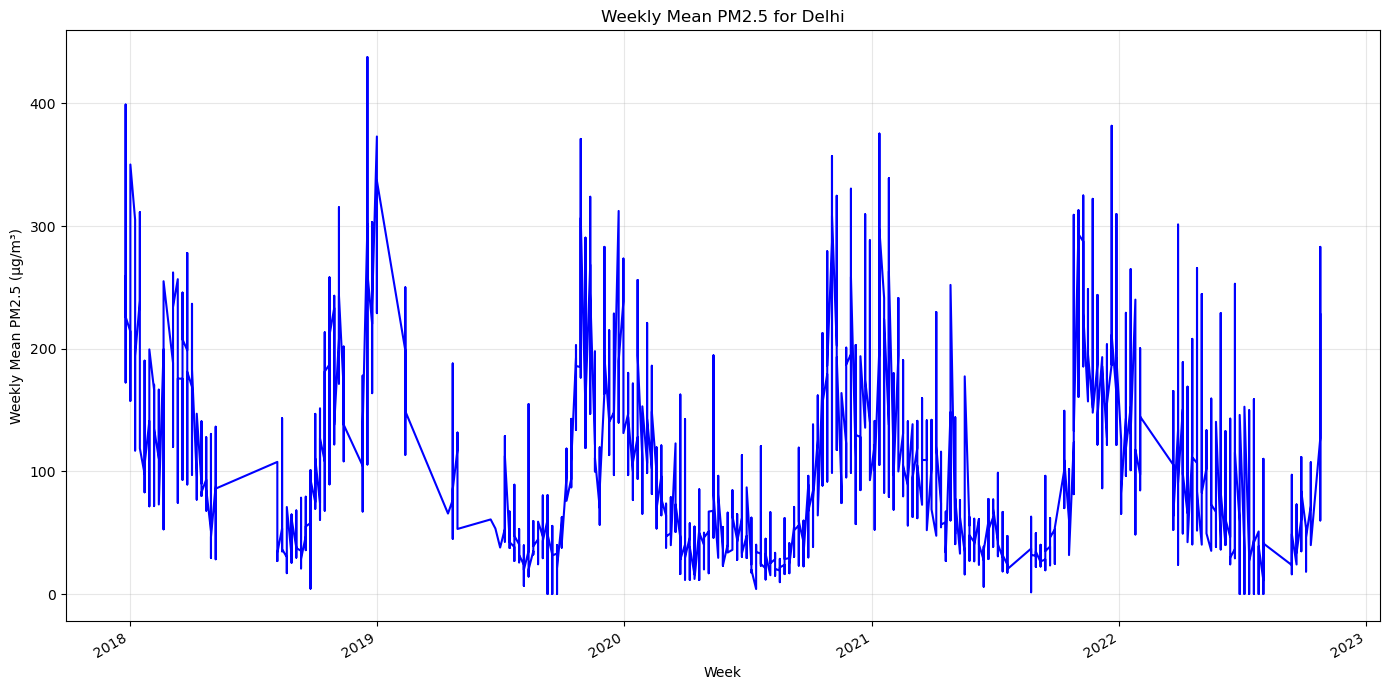

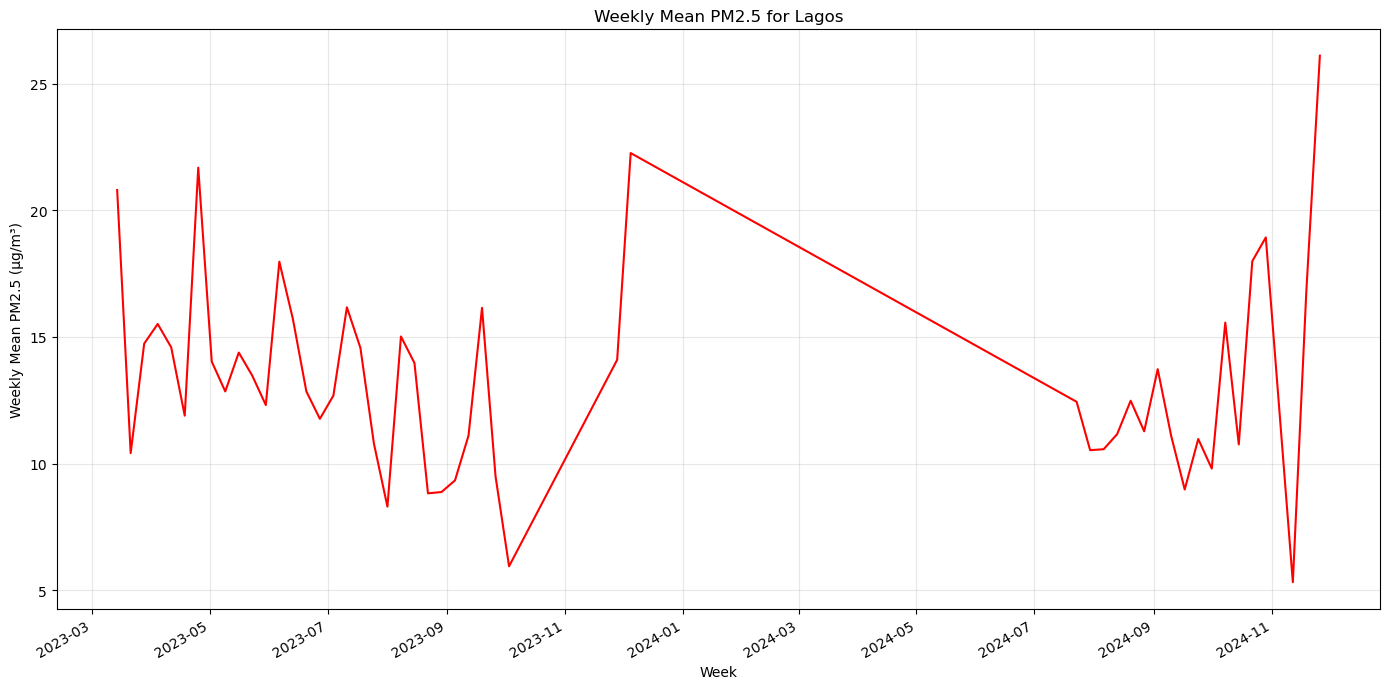

In [27]:
# Create weekly aggregated dataframes for both cities
# First, add a week column to each dataframe
df_delhi_raw['week'] = df_delhi_raw['datetime'].dt.to_period('W-MON').dt.start_time
df_lagos_raw['week'] = df_lagos_raw['datetime'].dt.to_period('W-MON').dt.start_time

# Function to create weekly aggregated data
def create_weekly_aggregation(df):
    # Group by sensor ID and week, then calculate statistics
    weekly_df = (df.groupby(['sid', 'week'], as_index=False)
                  .agg(
                      pm25_mean=('value', 'mean'),
                      pm25_median=('value', 'median'),
                      pm25_min=('value', 'min'),
                      pm25_max=('value', 'max'),
                      latitude=('latitude', 'first'),
                      longitude=('longitude', 'first'),
                      location_id=('location_id', 'first'),
                      parameter_name=('parameter.name', 'first'),
                      parameter_units=('parameter.units', 'first'),
                      measurements=('value', 'count')
                  ))
    return weekly_df

# Create weekly aggregated dataframes
delhi_weekly = create_weekly_aggregation(df_delhi_raw)
lagos_weekly = create_weekly_aggregation(df_lagos_raw)

# Display the first few rows of each weekly dataframe
print("Delhi Weekly Aggregated Data:")
print(delhi_weekly.head())
print(f"\nTotal weeks of data: {len(delhi_weekly)}")

print("\nLagos Weekly Aggregated Data:")
print(lagos_weekly.head())
print(f"\nTotal weeks of data: {len(lagos_weekly)}")
# Sort dataframes by datetime before plotting
delhi_weekly_sorted = delhi_weekly.sort_values('week')
lagos_weekly_sorted = lagos_weekly.sort_values('week')

# Plot 1: Delhi weekly mean PM2.5
plt.figure(figsize=(14, 7))
plt.plot(delhi_weekly_sorted['week'], delhi_weekly_sorted['pm25_mean'], 'b-', label='Delhi')
plt.xlabel('Week')
plt.ylabel('Weekly Mean PM2.5 (µg/m³)')
plt.title('Weekly Mean PM2.5 for Delhi')
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Plot 2: Lagos weekly mean PM2.5
plt.figure(figsize=(14, 7))
plt.plot(lagos_weekly_sorted['week'], lagos_weekly_sorted['pm25_mean'], 'r-', label='Lagos')
plt.xlabel('Week')
plt.ylabel('Weekly Mean PM2.5 (µg/m³)')
plt.title('Weekly Mean PM2.5 for Lagos')
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


In [32]:
# Save weekly aggregated dataframes to CSV files
delhi_weekly.to_csv('delhi_weekly_pm25.csv', index=False)
lagos_weekly.to_csv('lagos_weekly_pm25.csv', index=False)

print("Weekly aggregated data saved to CSV files:")
print("- delhi_weekly_pm25.csv")
print("- lagos_weekly_pm25.csv")

Weekly aggregated data saved to CSV files:
- delhi_weekly_pm25.csv
- lagos_weekly_pm25.csv
